# 00 - Preprocessing

This preprocessing notebook is used to construct a geopackage from the raw data, this geopackage is created from the gdf variable throughout this notebook.

In [1]:
# update this value to skip saving the output or skip generating visualizations when running this file
skip_visualizations = False
skip_saving_output = False

# update these values to change where final file is stored (must include .shp file name)
observations_final_file_path = '..\\output\\observation_data_s30.GEOJSON'
distributed_data_final_file_path = '..\\output\\distributed_data_s30.GEOJSON'

In [2]:
# default libs
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# vector geo data libs
import pandas as pd
import geopandas as gpd
import contextily as cx
# raster geo data libs
import rioxarray as rxr
# audio libs
import soundfile as sf
import waveform_analysis
# OLS
from sklearn import linear_model
import statsmodels.formula.api as smf
# noise removal
import noisereduce as nr

# script file, not a module 
import utils

## Reading in original data

In [3]:
# reading in gps data
gps_df = pd.read_csv('..\\data\\TestDriveNoise_8May2024.csv')

# preparing recordings, note recording 1 is redacted due to inaccurate volume levels
recordings_path = '..\\data\\may-collection-raw'
recording_files = [ #(file_name, dBAdjustment)
              ('101445-recording2.wav', 113), 
              ('103545-recording3.wav', 113), 
              ('111100-recording4.wav', 145), 
              ('121648-recording5.wav', 145)]


## Cleaning GPS data

In [99]:
# set datetime as datetime object
gps_df['DateTime'] = pd.to_datetime(gps_df['DateTime'], format='%Y-%m-%d %H:%M:%S')
# remove idle time in garage
gps_df = gps_df.iloc[3_100:].reset_index()

# apply simple kallman filter to smooth movement and obtain better speeds later
lats, longs = utils.simple_kallman(gps_df['Latitude'], gps_df['Longitude'])
gps_df['Latitude'] = lats
gps_df['Longitude'] = longs

# convert to geodataframe
gdf = gpd.GeoDataFrame(gps_df[['DateTime', 'Longitude', 'Latitude']], 
                       geometry=gpd.points_from_xy(gps_df.Longitude, gps_df.Latitude), 
                       crs="EPSG:4326")

# calculate velocity in a 5 wide frame (take value 2 indices before, and 2 after the convert to kmph)
gdf = gdf.to_crs("EPSG:28992") # NL based projection for more accurate distance between points
velocities = [gdf['geometry'][max(0, i-2)].distance(gdf['geometry'][min(gdf.shape[0]-1, i+2)])/5*3.6
              for i in range(gdf.shape[0])]
gdf['speed'] = velocities

# clean up notebook
del velocities, lats, longs

## Appending Recordings to full DF

In [100]:
# TODO write function descriptions
def signal_to_res(signal_frame, sr):
    weighted_signal = waveform_analysis.A_weight(signal_frame, sr)
    rms_value = np.sqrt(np.mean(np.abs(weighted_signal)**2))
    result = 20 * np.log10(rms_value)
    
    return result

def db_time_array(signal, sr, frame_duration=1, overlap=None):
    """
    args: 
    frame_size: in seconds
    """
    frame_size = int(frame_duration*sr)
    s_frame, e_frame = 0, frame_size+1
    result = []
    while e_frame < len(signal):
        result.append(signal_to_res(signal[s_frame:e_frame], sr))
        s_frame, e_frame = e_frame, e_frame+frame_size
    result.append(signal_to_res(signal[s_frame:], sr))
    return result

def file_to_db_list(filename, db_increment = 150):
    # 150 based on 74db tone file test
    # read in audio data
    data_folder = '..\\data\\may-collection-raw'
    file_path = os.path.join(data_folder, filename)
    signal, sr = sf.read(file_path)
    # attempt to remove buzz
    # noise_clip, srn = sf.read(os.path.join(data_folder, 'achterafDbTest.wav'))
    # noise_clip = noise_clip[:int(7.5*srn)]
    # signal = nr.reduce_noise(y=signal, sr=sr, y_noise=noise_clip, stationary=False, prop_decrease=0.5)

    # convert to dBA values
    db_array = db_time_array(signal, sr, 1)
    db_array = [x + db_increment for x in db_array]
    return db_array

In [101]:
# create array with dB levels for each second in gps gdf
full_db_array = np.full(gdf.shape[0], np.NaN)

for file, adj in recording_files:
    dBA = file_to_db_list(file, adj)
    timestamp = f"2024-05-08 {int(file[:2])-2}:{file[2:4]}:{file[4:6]}"
    index = gdf[gdf['DateTime'] == timestamp].index.values[0]
    full_db_array[index:index+len(dBA)] = dBA

gdf['dBA_raw'] = full_db_array

# clean up notebook
del full_db_array

In [102]:
gdf = gdf[gdf['speed'] <= 30]

## Regression Based Wind Interference Removal


In [103]:
# to run the regression, remove all x values (time) without y value (dBA)
regression_gdf = gdf.dropna()
# run ordinary least squared
reg = linear_model.LinearRegression().fit(regression_gdf[['speed']], regression_gdf[['dBA_raw']])
gdf['dBA_reg_adj'] = gdf['dBA_raw'] - reg.coef_[0][0] * gdf['speed']
# print regression details
print(f"OLS score: {reg.score(regression_gdf[['speed']], regression_gdf[['dBA_raw']])}")
print(f"coef_: {reg.coef_} intercept_: {reg.intercept_}")

#clean up notebook
del regression_gdf

OLS score: 0.38172198075828123
coef_: [[0.43041774]] intercept_: [69.06804247]


## DNN Based Wind Interference Removal

In [104]:
# TODO

## Creating Standardized Point GDF with Reference Lden
For modelling purposes, current GDF is unsuitable. Instead a raster-like approach is taken with a point vector representing a 10x10m area, similar to the approach by the RIVM. This approach is chosen for easier integration of reference values for Lden from the RIVM.

In [105]:
# importing lden values from RIVM data
rds = rxr.open_rasterio("..\\data\\rivm-lden\\rivm_20220601_Geluid_lden_allebronnen_2020_v2.tif")
rds.name = "dBA_rivm"
# clipping to Utrecht general area
rds = rds.rio.clip_box(minx=129739.1234,miny=450112.6341,
                        maxx=142817.4583,maxy=461586.9908)
# converting to geodataframe (each raster becomes a point vector, 
# with each point representing a 10mx10m raster square)
df = rds.squeeze().to_dataframe().reset_index()
geometry = gpd.points_from_xy(df.x, df.y)
lden_gdf = gpd.GeoDataFrame(df, crs=rds.rio.crs, geometry=geometry)
lden_gdf = lden_gdf[['y', 'x', 'dBA_rivm', 'geometry']]

# define values to transfer
column_map = [#('cd_column', 'aggregate_array_column', 'median_column'),
                ('speed', 'speed_arr', 'median_speed'),
                ('dBA_raw', 'dBA_raw_arr', 'median_dBA_raw'),
                ('dBA_reg_adj', 'dBA_reg_arr', 'median_dBA_reg_adj'),
                #TODO ('dBA_dnn_adj', 'dBA_dnn_arr', 'median_dBA_dnn_adj'),
              ]

# for each measurement find the closest raster square
gdf_nearest = gpd.sjoin_nearest(lden_gdf, gdf[['geometry'] + [v[0] for v in column_map]],
                        how='right') # note both gdf's should be in ECRS 28992

# create new gdf with columns to save all measured dBA values for each raster square
combined_gdf = lden_gdf
for _, agg_col, _ in column_map:
  combined_gdf[agg_col] = [[] for _ in range(combined_gdf.shape[0])]

# populate dBA value columns
for i, r in gdf_nearest.iterrows():
    for cd_col, agg_col, _ in column_map:
        combined_gdf[agg_col][r['index_left']].append(r[cd_col])

# get the median dBA value for each value
for _, agg_col, median_col in column_map:
   combined_gdf[median_col] = combined_gdf[agg_col].apply(lambda l: np.NaN if not l else np.median(l))

# cleaning up notebook memory
del gdf_nearest, column_map, rds, df, geometry

In [106]:
combined_gdf.columns

Index(['y', 'x', 'dBA_rivm', 'geometry', 'speed_arr', 'dBA_raw_arr',
       'dBA_reg_arr', 'median_speed', 'median_dBA_raw', 'median_dBA_reg_adj'],
      dtype='object')

## Saving Resulting GDFs

In [107]:
if not skip_saving_output:
    # * saving observation data
    gdf.to_file(observations_final_file_path)
    gdf.to_csv(f'{observations_final_file_path[:-8]}.csv')
    print('Finished saving observation data to files')
    # * saving distributed data
    # (arrays cannot be stored and should be unnecessary, thus are removed)
    del combined_gdf['speed_arr'], combined_gdf['dBA_raw_arr'], combined_gdf['dBA_reg_arr']
    combined_gdf.to_file(distributed_data_final_file_path, engine='pyogrio', use_arrow=True)
    print('tofiledone')
#     gdf = gpd.read_file("..\\data\\nwb_wegen.gpkg", engine='pyogrio', use_arrow=True)
# #800MB file, first run took approx >120s without engines (didnt finish)
# #with pyogrio and pyarrow: 10s but 1 UswerWarning
    combined_gdf.to_csv(f'{distributed_data_final_file_path[:-8]}.csv')
    print('Finished saving distributed observation point data to files')



Finished saving observation data to files
tofiledone
Finished saving distributed observation point data to files


## Simple visualization of observations

In [108]:
# Forcefully ending notebook here if visualizations should be skipped
if skip_visualizations: raise Exception('Notebook ended early to skip visualizations as skip_visualizations was set to True at top of notebook.') 

In [109]:
# Ensuring consistent colour scales
cmap = mpl.colormaps['plasma']
norm = mpl.colors.Normalize(vmin=40, vmax=110)

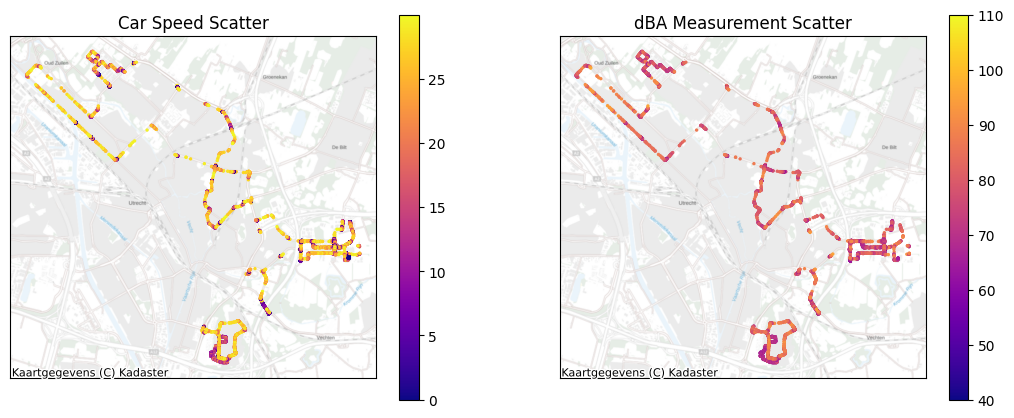

In [110]:
# Collection route overview (speed and raw dBA)
# gdf = gdf.to_crs("EPSG:4326")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))
gdf = gdf.to_crs("EPSG:28992")

gdf.plot(column = 'speed', figsize=(6.5,5), legend=True, ax=ax1,
              markersize=2, cmap=cmap)
ax1.set_title('Car Speed Scatter')
gdf.plot(column = 'dBA_raw', figsize=(6.5,5), legend=True, ax=ax2,
             markersize=2, cmap=cmap, norm=norm)
ax2.set_title('dBA Measurement Scatter')

for ax in (ax1, ax2):
    ax.set_xticks([]); ax.set_yticks([])
    cx.add_basemap(ax, source=cx.providers.nlmaps.grijs, crs=gdf.crs)


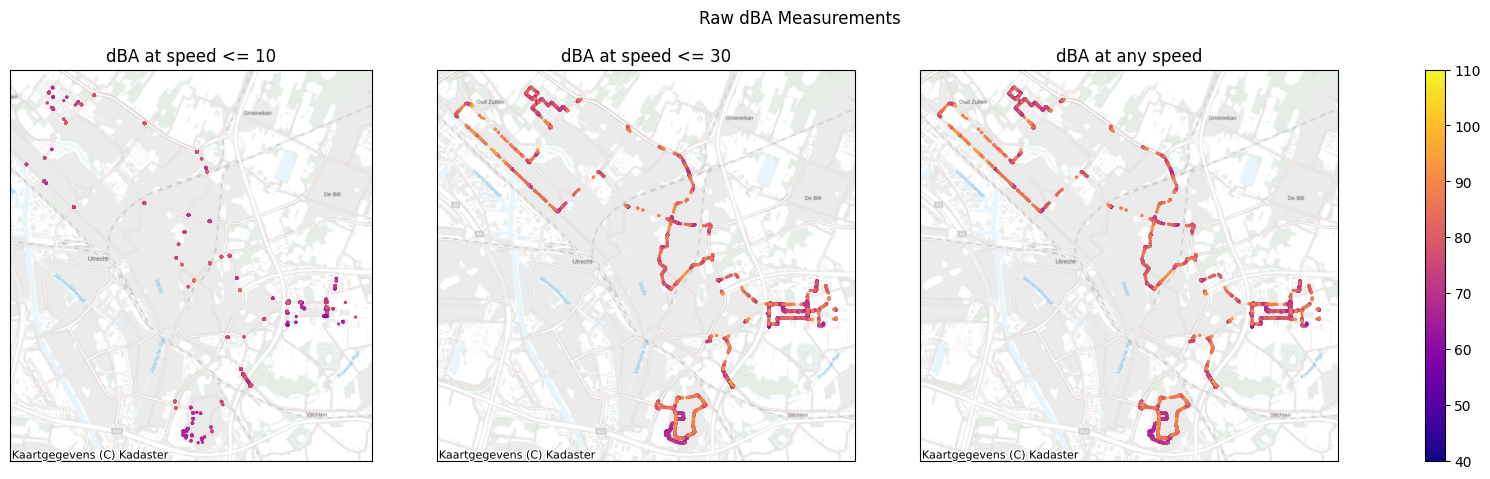

In [111]:
# Raw dBA values, seperated by maximum car speed
fig = plt.figure(figsize=(18,5))
spec = mpl.gridspec.GridSpec(ncols=3, nrows=1, height_ratios=[1], width_ratios=[1,1,1])

ax1 = fig.add_subplot(spec[0, 0])
gdf[gdf['speed'] <= 10].plot(column = 'dBA_raw', ax=ax1,
              markersize=2, cmap=cmap, norm=norm)
ax1.set_title('dBA at speed <= 10')
ax2 = fig.add_subplot(spec[0, 1])
gdf[gdf['speed'] <= 30].plot(column = 'dBA_raw', ax=ax2,
              markersize=2, cmap=cmap, norm=norm)
ax2.set_title('dBA at speed <= 30')
ax3 = fig.add_subplot(spec[0, 2])
gdf[gdf['speed'] <= np.inf].plot(column = 'dBA_raw', ax=ax3,
              markersize=2, cmap=cmap, norm=norm)
ax3.set_title('dBA at any speed')


fig.suptitle('Raw dBA Measurements')
plt.tight_layout()
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=(ax1,ax2,ax3))
for ax in (ax1, ax2, ax3):
    ax.set_xticks([]); ax.set_yticks([])
    cx.add_basemap(ax, source=cx.providers.nlmaps.grijs, crs=gdf.crs)

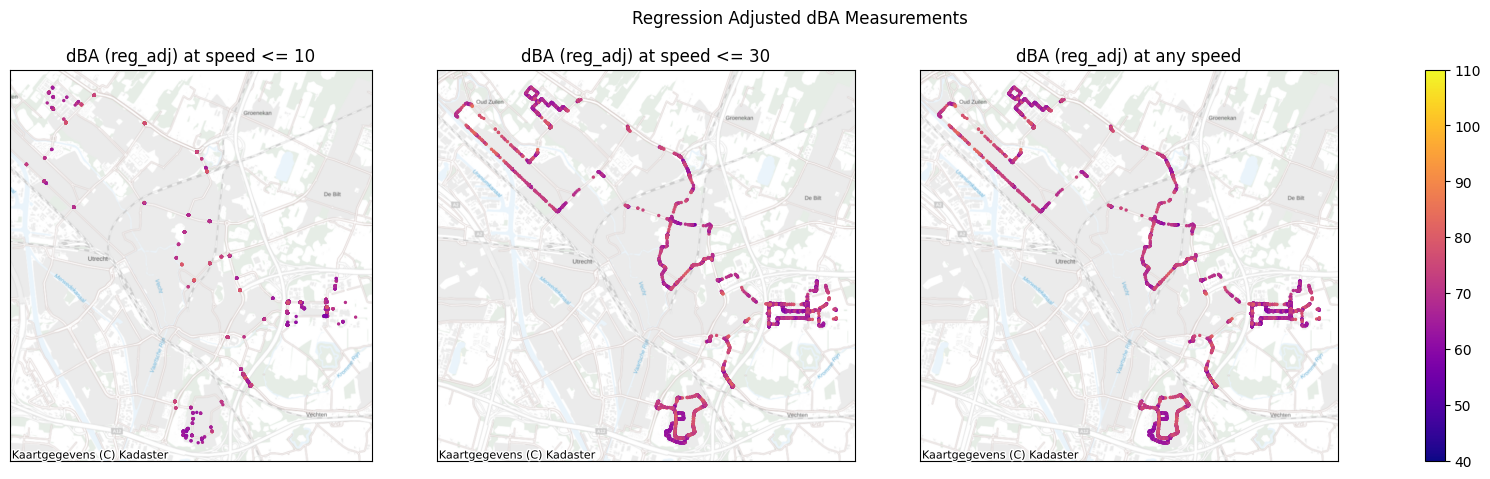

In [112]:
# Raw dBA values, seperated by maximum car speed
fig = plt.figure(figsize=(18,5))
spec = mpl.gridspec.GridSpec(ncols=3, nrows=1, height_ratios=[1], width_ratios=[1,1,1])
# norm = mpl.colors.Normalize(vmin=20, vmax=100)

ax1 = fig.add_subplot(spec[0, 0])
gdf[gdf['speed'] <= 10].plot(column = 'dBA_reg_adj', ax=ax1,
              markersize=2, cmap=cmap, norm=norm)
ax1.set_title('dBA (reg_adj) at speed <= 10')
ax2 = fig.add_subplot(spec[0, 1])
gdf[gdf['speed'] <= 30].plot(column = 'dBA_reg_adj', ax=ax2,
              markersize=2, cmap=cmap, norm=norm)
ax2.set_title('dBA (reg_adj) at speed <= 30')
ax3 = fig.add_subplot(spec[0, 2])
gdf[gdf['speed'] <= np.inf].plot(column = 'dBA_reg_adj', ax=ax3,
              markersize=2, cmap=cmap, norm=norm)
ax3.set_title('dBA (reg_adj) at any speed')


fig.suptitle('Regression Adjusted dBA Measurements')
plt.tight_layout()
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=(ax1,ax2,ax3))
for ax in (ax1, ax2, ax3):
    ax.set_xticks([]); ax.set_yticks([])
    cx.add_basemap(ax, source=cx.providers.nlmaps.grijs, crs=gdf.crs)

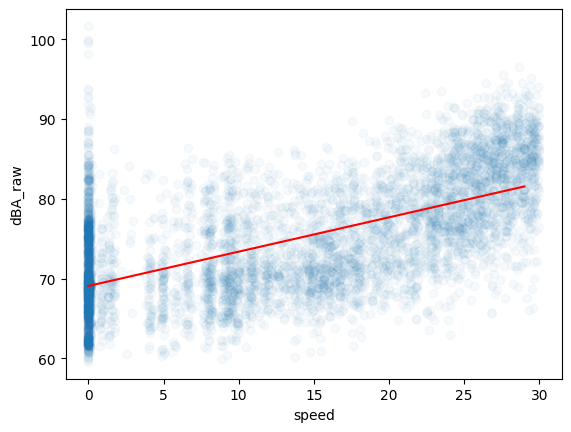

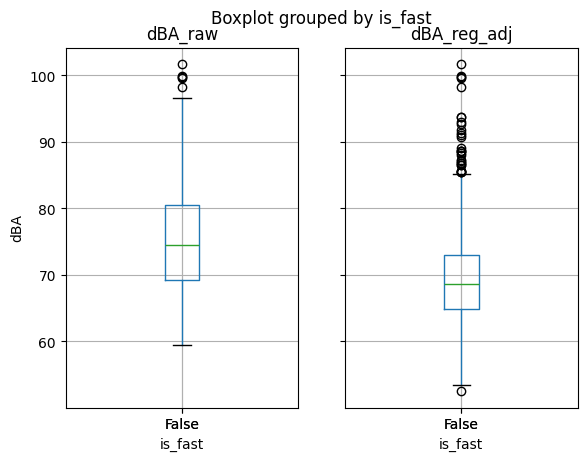

                            OLS Regression Results                            
Dep. Variable:                dBA_raw   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     3683.
Date:                Thu, 13 Jun 2024   Prob (F-statistic):               0.00
Time:                        09:36:45   Log-Likelihood:                -18896.
No. Observations:                5968   AIC:                         3.780e+04
Df Residuals:                    5966   BIC:                         3.781e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     69.0680      0.123    562.035      0.0

In [113]:
# Regression analysis/overview

# scatter plot speed ~ dBA with regression line
plt.scatter(gdf['speed'], gdf['dBA_raw'], alpha=0.03)
x_range = range(round(gdf['speed'].min()), round(gdf['speed'].max()))
plt.plot(x_range, #x
         [reg.intercept_[0] + reg.coef_[0][0] * x for x in x_range], #y 
         color='red')
plt.xlabel('speed')
plt.ylabel('dBA_raw')
plt.show()

# box plot comparing dBA values for raw vs adjusted at low and high speeds
gdf['is_fast'] = gdf['speed'] > 30
gdf.boxplot(column=['dBA_raw', 'dBA_reg_adj'], by='is_fast', ylabel='dBA')

plt.show()

# regression summary
ols = smf.ols('dBA_raw ~ speed', data=gdf).fit()
print(ols.summary())